# Chapter 3.1

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics

## Set seed

In [3]:
np.random.seed(2020)

## Node remover function

In [4]:
def remove_random_nodes(n, weights, to_consider=None):
    if to_consider:
        to_drop = np.random.choice(to_consider, n, replace=False)
    else:
        to_drop = np.random.choice(len(weights[1]), n, replace=False)
    for i in to_drop:
        weights[0][:,i] = 0
        weights[1][i] = 0
        weights[2][i,:] = 0
    return weights, to_drop

In [5]:
def shrink_model_randomly(model, acc, loss, weights, n, to_test, x_train, y_train, v=0):
    new_loss = loss
    new_acc = acc
    ba = acc
    bl = loss
    best_model = copy.deepcopy(weights)
    num_removed = 0
    best_score = 0
    to_consider = list(np.arange(len(weights[1])))
    for _ in range(to_test):
        new = copy.deepcopy(best_model)
        new, dropped = remove_random_nodes(n, new, to_consider)
        model.set_weights(new)
        new_loss, new_acc = model.evaluate(x_train, y_train, verbose=v)
        score = (1 - (new_loss / bl)) + ((new_acc / ba) - 1)
        if best_score < score:
            ba = new_acc
            bl = new_loss
            best_model = copy.deepcopy(new)
            num_removed += n
            for node in dropped:
                to_consider.remove(node)
    return best_model, num_removed

### Single-Layer ANN

## MNIST

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [7]:
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2625 - accuracy: 0.9251 - val_loss: 0.1394 - val_accuracy: 0.9583
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1173 - accuracy: 0.9651 - val_loss: 0.1074 - val_accuracy: 0.9662
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0807 - accuracy: 0.9756 - val_loss: 0.0841 - val_accuracy: 0.9739
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0608 - accuracy: 0.9812 - val_loss: 0.0864 - val_accuracy: 0.9731
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0454 - accuracy: 0.9862 - val_loss: 0.0734 - val_accuracy: 0.9770


In [8]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0734 - accuracy: 0.9770


In [9]:
original_weights = model.get_weights()

In [10]:
nums_to_rem = [64, 32, 16, 8, 4, 2, 1]
trials = 1000
new_accs = []
new_losses = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    for _ in tqdm.trange(trials):
        tmp = copy.deepcopy(original_weights)
        tmp, _ = remove_random_nodes(ntr, tmp)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
    new_accs += [accs]
    new_losses += [losses]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


In [11]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_mnist.csv')
A = A.T
A.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.855520,0.946356,0.965762,0.972368,0.975001,0.976046,0.976517
std,0.039356,0.012245,0.005288,0.002671,0.001527,0.001030,0.000708
min,0.659800,0.868800,0.933700,0.949400,0.963500,0.966000,0.974000
25%,0.833075,0.940975,0.963200,0.971000,0.974200,0.975600,0.976200
50%,0.861550,0.948900,0.966900,0.972800,0.975300,0.976200,0.976700
75%,0.883650,0.954300,0.969500,0.974200,0.976000,0.976700,0.977000
max,0.933400,0.968500,0.976900,0.976900,0.977900,0.978000,0.977800


In [12]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_mnist.csv')
L = L.T
L.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.429829,0.167953,0.108968,0.088509,0.080063,0.076718,0.075111
std,0.098869,0.033792,0.015676,0.008273,0.004722,0.003247,0.002310
min,0.231069,0.100565,0.079057,0.073502,0.070959,0.071416,0.071990
25%,0.362054,0.145536,0.097992,0.082942,0.076752,0.074667,0.073658
50%,0.413818,0.161033,0.105505,0.086929,0.078990,0.075834,0.074365
75%,0.479963,0.183209,0.116596,0.092543,0.082424,0.077891,0.075677
max,0.944893,0.384799,0.192072,0.152969,0.116659,0.110218,0.086447


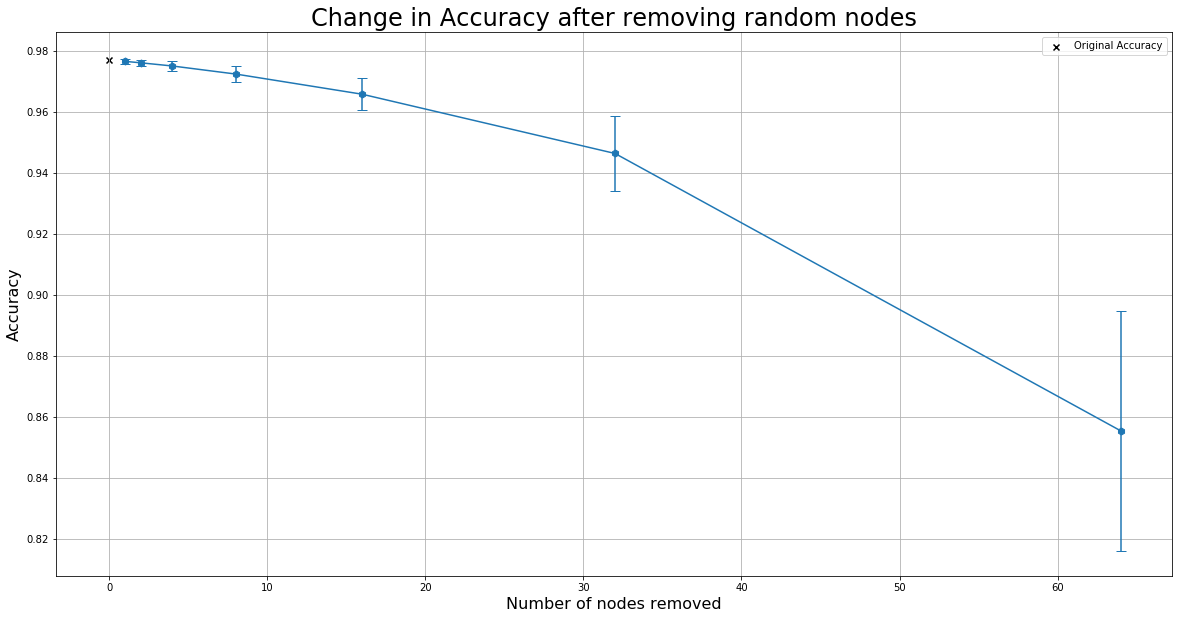

In [13]:
ma = A.mean().to_numpy()
stda = A.std().to_numpy()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(x=nums_to_rem, y=ma, yerr=stda, capsize=5, marker='h', markersize=7, alpha=1)
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy")
plt.legend()
plt.title("Change in Accuracy after removing random nodes", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Accuracy", size=16)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_change_random_removal_mnist.png")

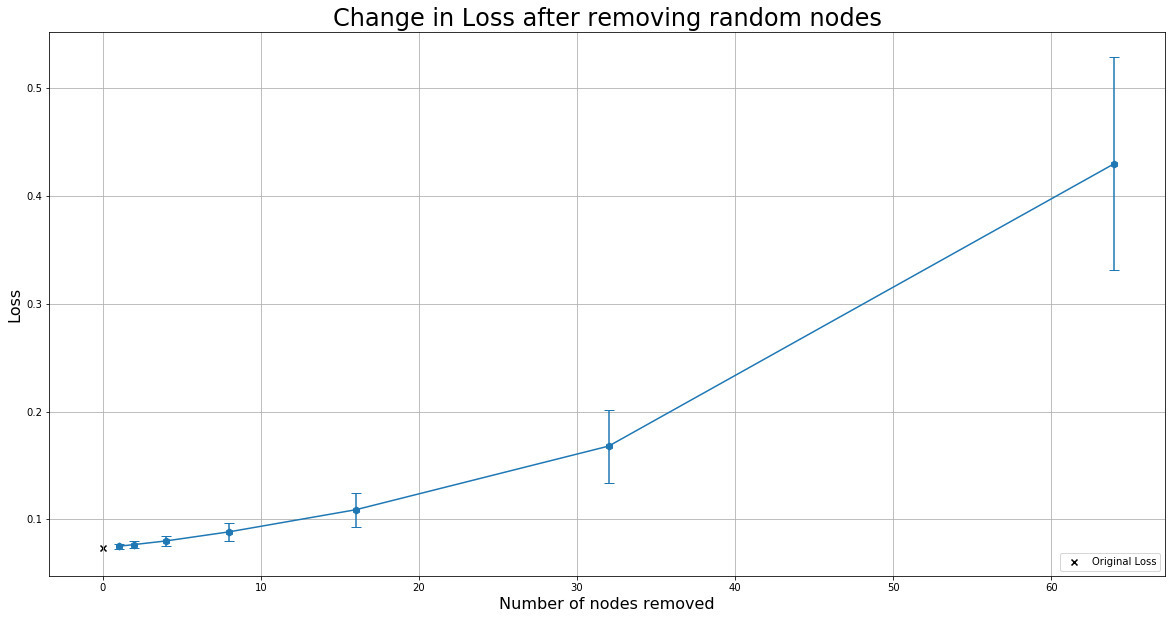

In [14]:
ml = L.mean().to_numpy()
stdl = L.std().to_numpy()
plt.errorbar(x=nums_to_rem, y=ml, yerr=stdl, capsize=5, marker='h', markersize=7, alpha=1)
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss")
plt.legend(loc='lower right')
plt.title("Change in Loss after removing random nodes", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Loss", size=16)
plt.grid(True)
plt.savefig("../../../figures/Loss_change_random_removal_mnist.png")

In [15]:
model.set_weights(original_weights)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
nums_to_rem = [8, 4, 3, 2, 1]
trials = 20
check = 64
new_accs = []
new_losses = []
nums_rem = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    num_rem = []
    for _ in tqdm.trange(trials):
        tmp, nr = shrink_model_randomly(model, train_acc, train_loss, original_weights, ntr, check, x_train, y_train)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
        num_rem += [nr]
    new_accs += [accs]
    new_losses += [losses]
    nums_rem += [num_rem]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [24:50<00:00, 74.54s/it]


In [16]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_improving_mnist.csv')
A = A.T
A.describe()

,8,4,3,2,1
count,20.000,20.000000,20.000000,20.000000,20.000000
mean,0.977,0.977050,0.977175,0.977205,0.977510
std,0.000,0.000443,0.000423,0.000589,0.000495
min,0.977,0.976200,0.976300,0.976200,0.976600
25%,0.977,0.977000,0.977000,0.976775,0.977100
50%,0.977,0.977000,0.977000,0.977200,0.977650
75%,0.977,0.977000,0.977300,0.977600,0.977850
max,0.977,0.978200,0.978200,0.978700,0.978300


In [17]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_improving_mnist.csv')
L = L.T
L.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.073397,0.073402,0.073185,0.073038,0.072666
std,0.000000,0.000665,0.000535,0.001107,0.000876
min,0.073397,0.070991,0.071366,0.070350,0.071035
25%,0.073397,0.073397,0.073279,0.072648,0.072028
50%,0.073397,0.073397,0.073397,0.073387,0.072685
75%,0.073397,0.073456,0.073397,0.073748,0.073166
max,0.073397,0.074931,0.073517,0.074528,0.074143


In [18]:
NR = pd.DataFrame(nums_rem, index = nums_to_rem)
NR.to_csv('../../../results/number_nodes_removed_random_removal_improving_mnist.csv')
NR = NR.T
NR.describe()

,8,4,3,2,1
count,20.0,20.000000,20.000000,20.000000,20.000000
mean,0.0,1.400000,1.350000,3.200000,4.200000
std,0.0,1.957442,1.814416,1.641565,1.321881
min,0.0,0.000000,0.000000,2.000000,1.000000
25%,0.0,0.000000,0.000000,2.000000,3.000000
50%,0.0,0.000000,0.000000,2.000000,5.000000
75%,0.0,4.000000,3.000000,4.000000,5.000000
max,0.0,4.000000,6.000000,8.000000,6.000000


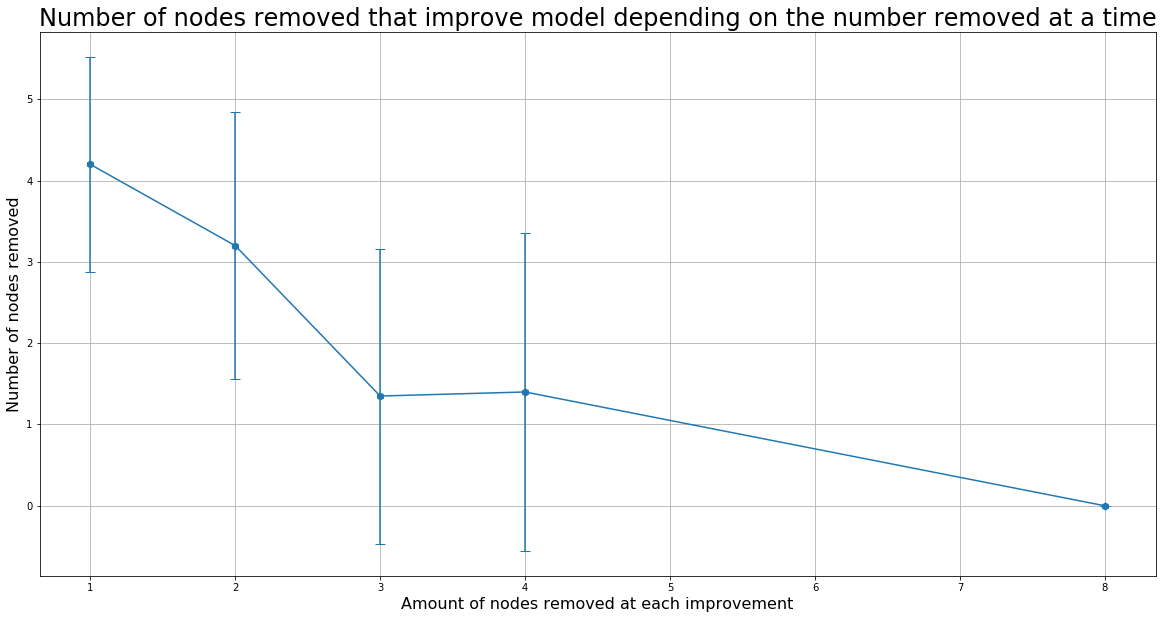

In [19]:
mnr = NR.mean().to_numpy()
stdnr = NR.std().to_numpy()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(x=nums_to_rem, y=mnr, yerr=stdnr, capsize=5, marker='h', markersize=7, alpha=1)
plt.title("Number of nodes removed that improve model depending on the number removed at a time", size=24)
plt.xlabel("Amount of nodes removed at each improvement", size=16)
plt.ylabel("Number of nodes removed", size=16)
plt.grid(True)
plt.savefig("../../../figures/Num_rem_vs_size_removed_mnist.png")

In [20]:
num_removed = [nr for num_rem in nums_rem for nr in num_rem]
new_accs = [a for accs in new_accs for a in accs]
new_losses = [l for losses in new_losses for l in losses]

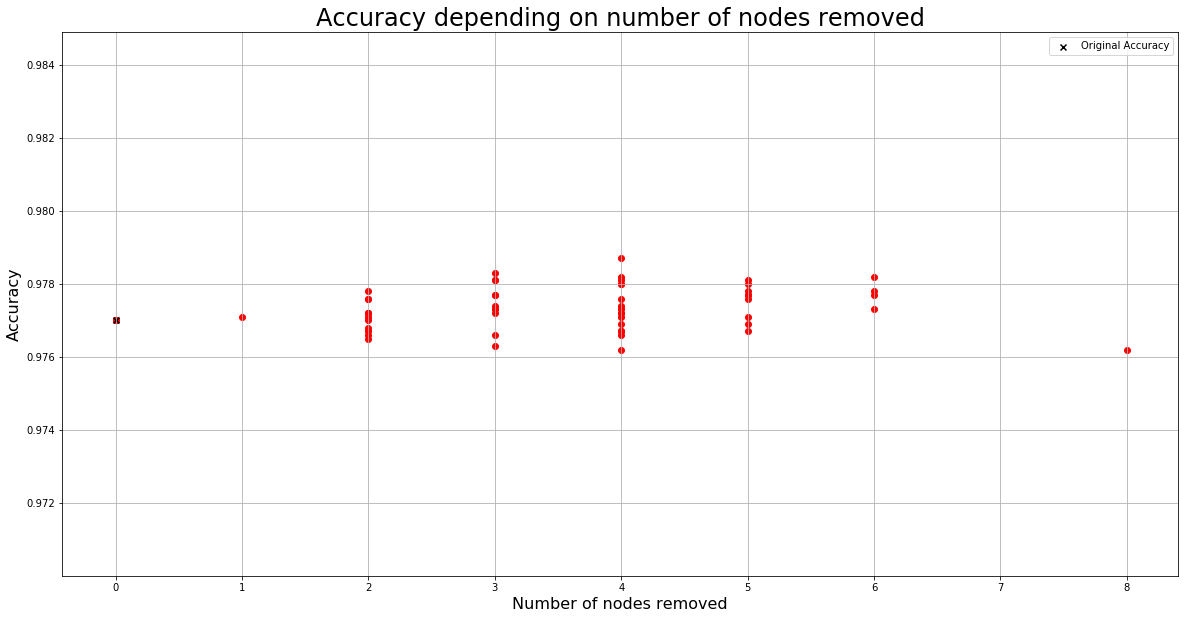

In [21]:
plt.scatter(x=num_removed, y=new_accs, marker='o', color='red')
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy")
plt.legend()
plt.title("Accuracy depending on number of nodes removed", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Accuracy", size=16)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_vs_nodes_removed_mnist.png")

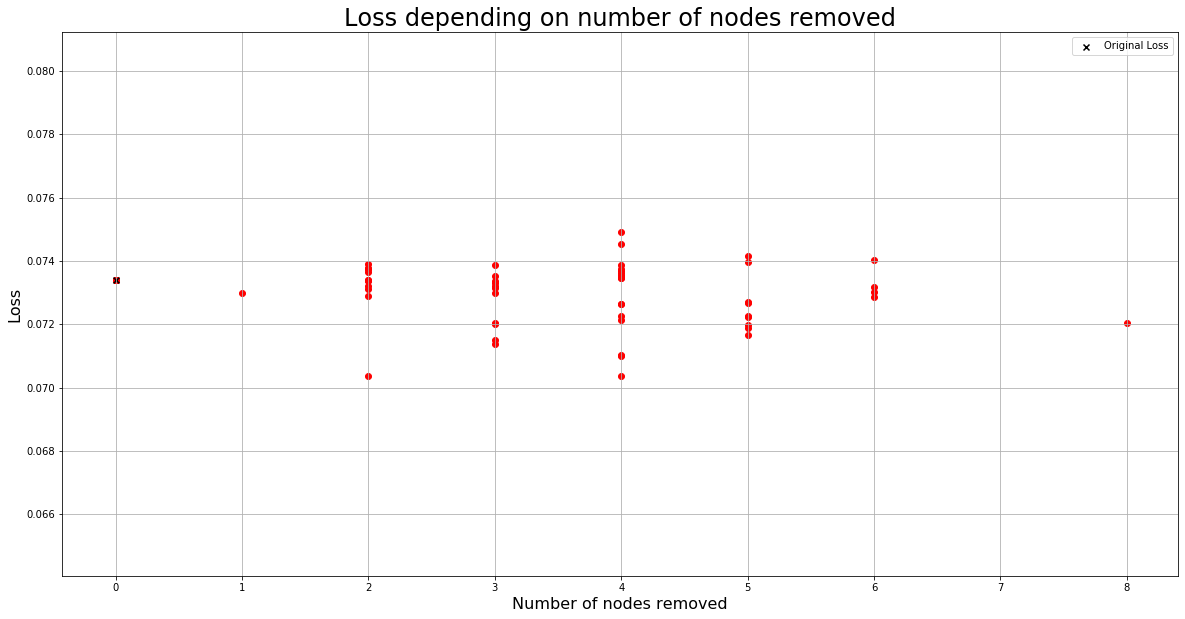

In [22]:
plt.scatter(x=num_removed, y=new_losses, marker='o', color='red')
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss")
plt.legend()
plt.title("Loss depending on number of nodes removed", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Loss", size=16)
plt.grid(True)
plt.savefig("../../../figures/Loss_vs_nodes_removed_mnist.png")

## Fashion MNIST

In [23]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [24]:
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4942 - accuracy: 0.8257 - val_loss: 0.4264 - val_accuracy: 0.8459
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3721 - accuracy: 0.8660 - val_loss: 0.4447 - val_accuracy: 0.8373
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3340 - accuracy: 0.8766 - val_loss: 0.3914 - val_accuracy: 0.8571
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3105 - accuracy: 0.8852 - val_loss: 0.3807 - val_accuracy: 0.8615
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2920 - accuracy: 0.8921 - val_loss: 0.3425 - val_accuracy: 0.8785
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2778 - accuracy: 0.8962 - val_loss: 0.3405 - val_accuracy: 0.8794
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2653 - accuracy: 0.9002 - val_loss: 0.3373 - val_accuracy:

In [25]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.3625 - accuracy: 0.8713


In [26]:
original_weights = model.get_weights()

In [7]:
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2625 - accuracy: 0.9251 - val_loss: 0.1394 - val_accuracy: 0.9583
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1173 - accuracy: 0.9651 - val_loss: 0.1074 - val_accuracy: 0.9662
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0807 - accuracy: 0.9756 - val_loss: 0.0841 - val_accuracy: 0.9739
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0608 - accuracy: 0.9812 - val_loss: 0.0864 - val_accuracy: 0.9731
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0454 - accuracy: 0.9862 - val_loss: 0.0734 - val_accuracy: 0.9770


In [8]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0734 - accuracy: 0.9770


In [9]:
original_weights = model.get_weights()

In [27]:
nums_to_rem = [64, 32, 16, 8, 4, 2, 1]
trials = 1000
new_accs = []
new_losses = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    for _ in tqdm.trange(trials):
        tmp = copy.deepcopy(original_weights)
        tmp, _ = remove_random_nodes(ntr, tmp)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
    new_accs += [accs]
    new_losses += [losses]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.93it/s]


In [28]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_fmnist.csv')
A = A.T
A.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.751512,0.833434,0.855759,0.864365,0.868026,0.869778,0.870520
std,0.040416,0.017399,0.009869,0.006483,0.004265,0.002837,0.002264
min,0.590200,0.753600,0.800500,0.825600,0.845200,0.853700,0.857100
25%,0.728650,0.823875,0.850400,0.861275,0.866600,0.869100,0.870400
50%,0.755450,0.835300,0.857400,0.866000,0.869100,0.870600,0.871200
75%,0.780400,0.846600,0.863000,0.868900,0.870700,0.871300,0.871400
max,0.851900,0.870800,0.873400,0.875800,0.878800,0.875800,0.875300


In [29]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_fmnist.csv')
L = L.T
L.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.677158,0.460345,0.402080,0.380176,0.370959,0.366542,0.364544
std,0.100763,0.044347,0.025157,0.016553,0.010887,0.007115,0.005607
min,0.416089,0.369112,0.351280,0.345490,0.337567,0.347992,0.350949
25%,0.601989,0.428766,0.383566,0.368731,0.364312,0.362699,0.362531
50%,0.664717,0.455735,0.398778,0.376651,0.368910,0.364826,0.363370
75%,0.734530,0.483220,0.415200,0.388906,0.375246,0.368732,0.365606
max,1.186693,0.642725,0.526705,0.479386,0.421645,0.402913,0.390139


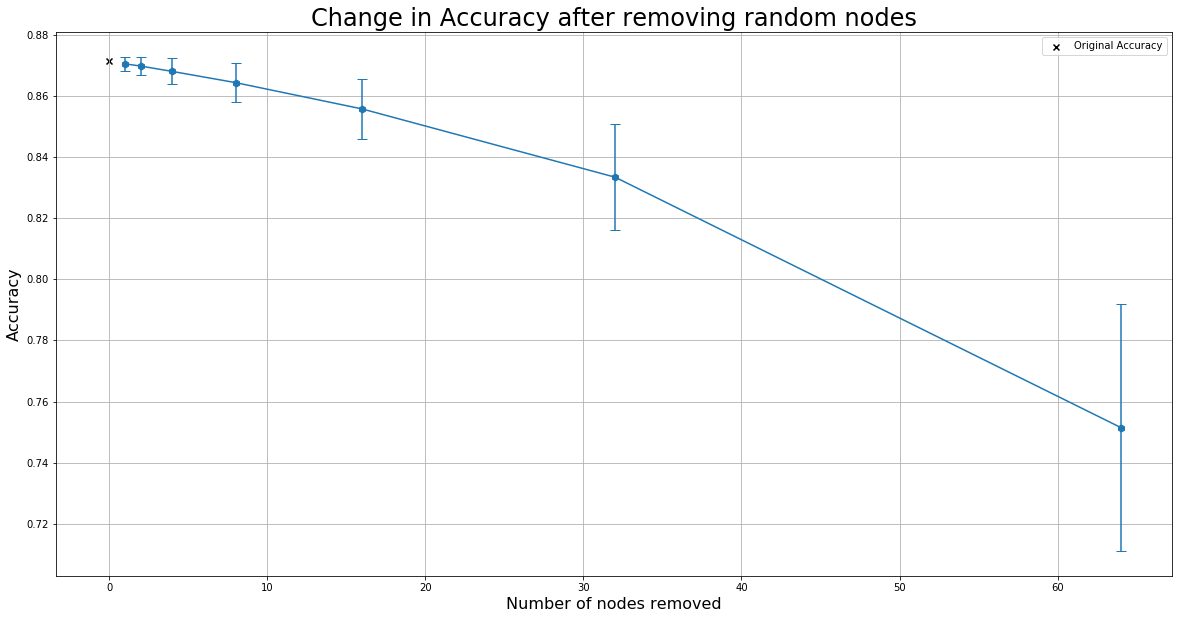

In [30]:
ma = A.mean().to_numpy()
stda = A.std().to_numpy()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(x=nums_to_rem, y=ma, yerr=stda, capsize=5, marker='h', markersize=7, alpha=1)
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy")
plt.legend()
plt.title("Change in Accuracy after removing random nodes", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Accuracy", size=16)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_change_random_removal_fmnist.png")

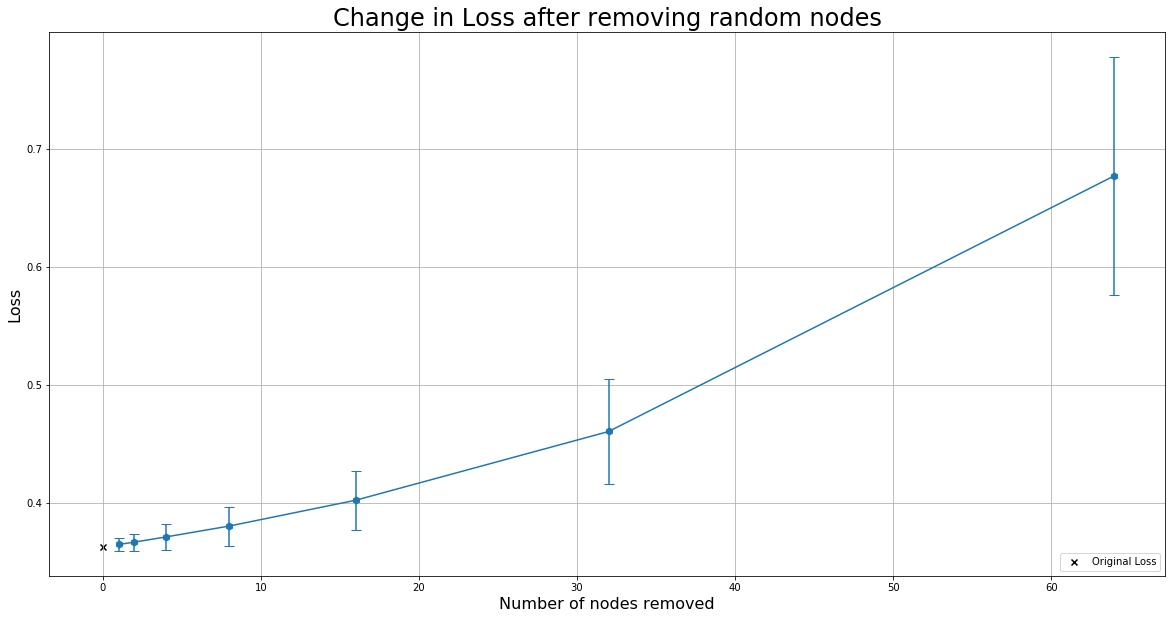

In [31]:
ml = L.mean().to_numpy()
stdl = L.std().to_numpy()
plt.errorbar(x=nums_to_rem, y=ml, yerr=stdl, capsize=5, marker='h', markersize=7, alpha=1)
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss")
plt.legend(loc='lower right')
plt.title("Change in Loss after removing random nodes", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Loss", size=16)
plt.grid(True)
plt.savefig("../../../figures/Loss_change_random_removal_fmnist.png")

In [32]:
model.set_weights(original_weights)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
nums_to_rem = [8, 4, 3, 2, 1]
trials = 20
check = 64
new_accs = []
new_losses = []
nums_rem = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    num_rem = []
    for _ in tqdm.trange(trials):
        tmp, nr = shrink_model_randomly(model, train_acc, train_loss, original_weights, ntr, check, x_train, y_train)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
        num_rem += [nr]
    new_accs += [accs]
    new_losses += [losses]
    nums_rem += [num_rem]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [24:46<00:00, 74.34s/it]


In [33]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_improving_fmnist.csv')
A = A.T
A.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.873330,0.875530,0.875745,0.876635,0.876065
std,0.001791,0.002327,0.002896,0.002545,0.002715
min,0.870900,0.871700,0.871500,0.872400,0.872400
25%,0.871900,0.873600,0.874075,0.874575,0.874100
50%,0.872900,0.875050,0.875000,0.877000,0.876150
75%,0.874925,0.877350,0.878700,0.878475,0.877275
max,0.876400,0.879700,0.881200,0.881900,0.882600


In [34]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_improving_fmnist.csv')
L = L.T
L.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.354215,0.345692,0.347863,0.342469,0.346329
std,0.004363,0.006011,0.005986,0.007486,0.007920
min,0.346624,0.332760,0.336065,0.332725,0.326458
25%,0.351114,0.341312,0.344275,0.336682,0.340955
50%,0.353750,0.346578,0.347882,0.340467,0.347525
75%,0.355921,0.349497,0.353029,0.347489,0.351757
max,0.362531,0.356190,0.356931,0.355368,0.357184


In [35]:
NR = pd.DataFrame(nums_rem, index = nums_to_rem)
NR.to_csv('../../../results/number_nodes_removed_random_removal_improving_fmnist.csv')
NR = NR.T
NR.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,9.200000,10.600000,9.300000,9.100000,5.000000
std,4.697144,4.357691,3.357631,2.468752,1.025978
min,0.000000,4.000000,3.000000,6.000000,3.000000
25%,8.000000,8.000000,6.000000,7.500000,4.750000
50%,8.000000,8.000000,9.000000,9.000000,5.000000
75%,10.000000,12.000000,12.000000,10.500000,6.000000
max,16.000000,20.000000,15.000000,14.000000,7.000000


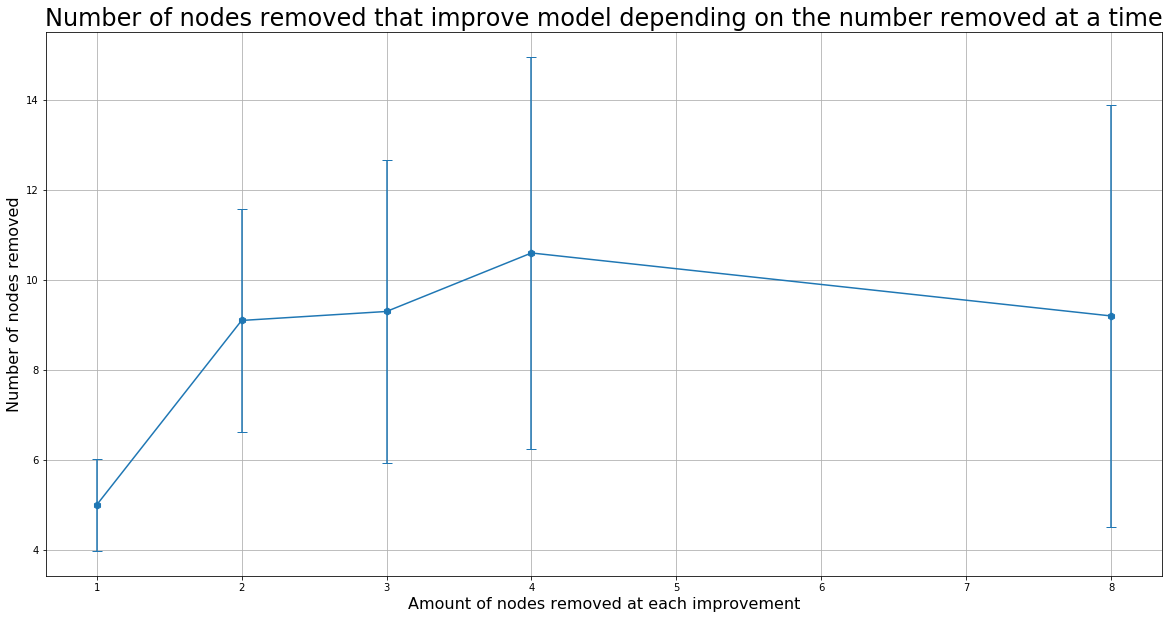

In [36]:
mnr = NR.mean().to_numpy()
stdnr = NR.std().to_numpy()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(x=nums_to_rem, y=mnr, yerr=stdnr, capsize=5, marker='h', markersize=7, alpha=1)
plt.title("Number of nodes removed that improve model depending on the number removed at a time", size=24)
plt.xlabel("Amount of nodes removed at each improvement", size=16)
plt.ylabel("Number of nodes removed", size=16)
plt.grid(True)
plt.savefig("../../../figures/Num_rem_vs_size_removed_fmnist.png")

In [37]:
num_removed = [nr for num_rem in nums_rem for nr in num_rem]
new_accs = [a for accs in new_accs for a in accs]
new_losses = [l for losses in new_losses for l in losses]

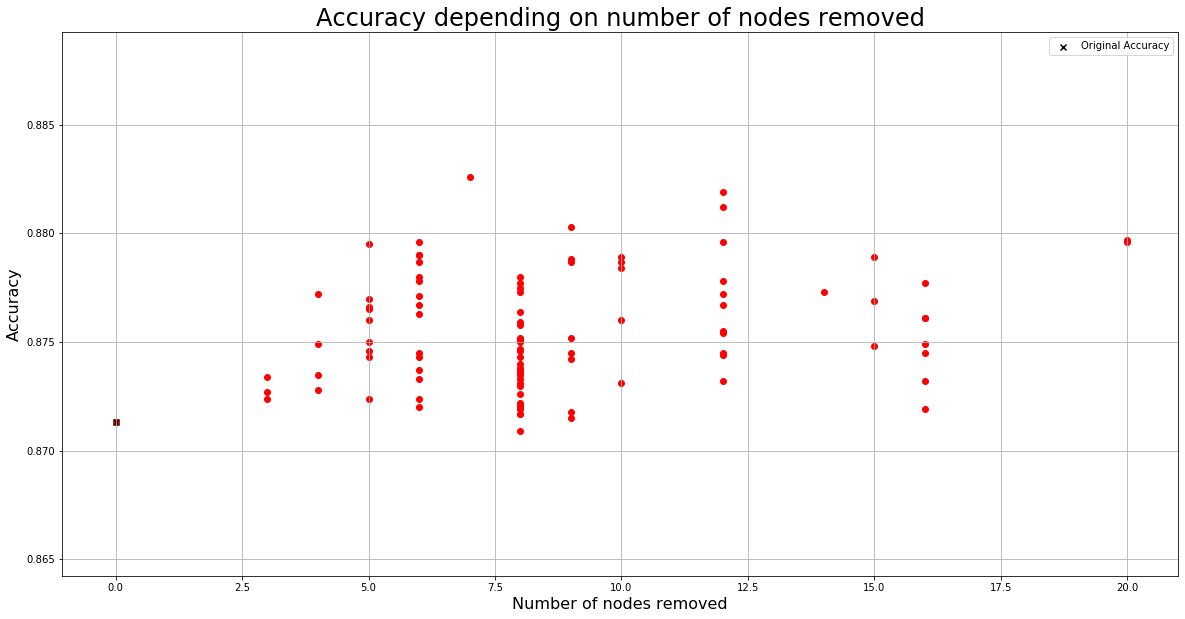

In [38]:
plt.scatter(x=num_removed, y=new_accs, marker='o', color='red')
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy")
plt.legend()
plt.title("Accuracy depending on number of nodes removed", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Accuracy", size=16)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_vs_nodes_removed_fmnist.png")

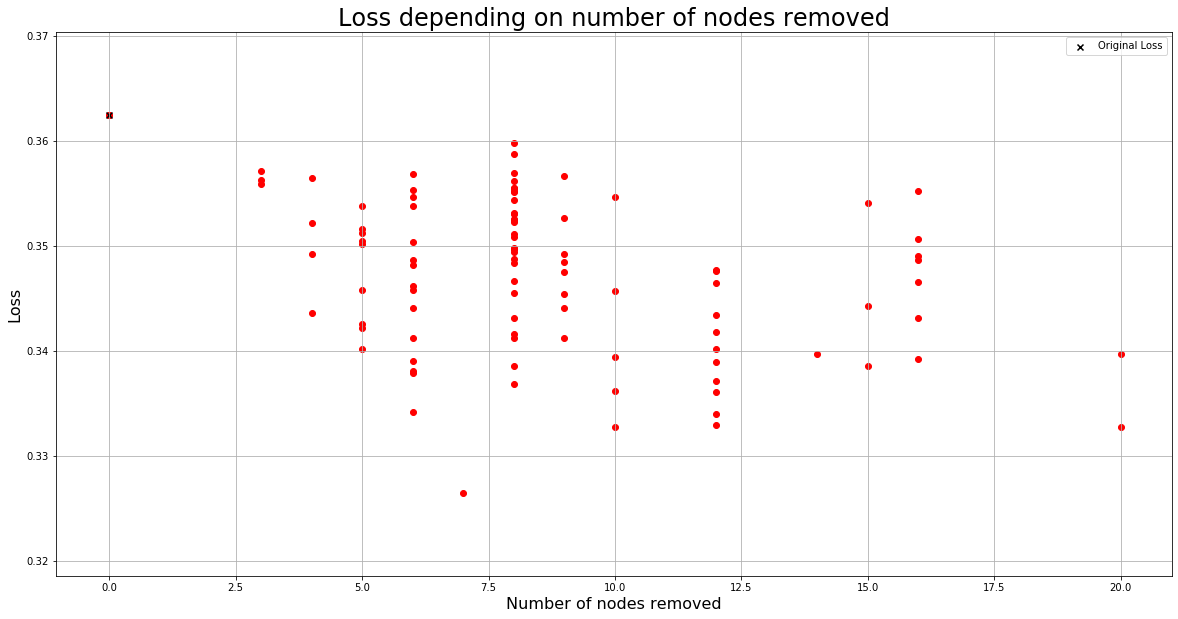

In [39]:
plt.scatter(x=num_removed, y=new_losses, marker='o', color='red')
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss")
plt.legend()
plt.title("Loss depending on number of nodes removed", size=24)
plt.xlabel("Number of nodes removed", size=16)
plt.ylabel("Loss", size=16)
plt.grid(True)
plt.savefig("../../../figures/Loss_vs_nodes_removed_fmnist.png")